# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# Your code here:
display(customers.head(),customers.shape)
print(customers.Region.value_counts())

customers.Channel = pd.Categorical(customers.Channel)
customers.Region = pd.Categorical(customers.Region)


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


(440, 8)

3    316
1     77
2     47
Name: Region, dtype: int64


In [4]:
customers.dtypes

Channel             category
Region              category
Fresh                  int64
Milk                   int64
Grocery                int64
Frozen                 int64
Detergents_Paper       int64
Delicassen             int64
dtype: object

In [5]:
# Your observations here
# Como se ve en el recuento de datos de Región se ve que la mayoria se encuentra en la región número 3


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [6]:
# Your code here
print(customers.isnull().sum(),customers.isna().sum())


Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64 Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64


In [7]:
# Your comment here
#Por ahora no creo que debamos cambiar nada del dataset ya que no otienen nulos y no veo que se deba quitar
#ninguna columna por su relación o procesarla.

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [8]:
columns = ["Fresh","Milk","Grocery","Frozen","Detergents_Paper","Delicassen"]
customer_Adapted = customers[columns]
customer_Adapted
otrasCategoricas = ["Channel","Region" ]
customer_Categoricas = customers[otrasCategoricas]
display(customer_Categoricas.head(2),customer_Adapted.head(2))

,Channel,Region
0,2,3
1,2,3


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776


In [9]:
# Your code here:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler().fit(customer_Adapted)

customers_scale = scaler.transform(customer_Adapted)

customers_scale = pd.DataFrame(customers_scale, columns=customer_Adapted.columns)
customers_scale = pd.concat([ customer_Categoricas,customers_scale,],axis=1, join='inner')

In [10]:
display(customers_scale)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339
1,2,3,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151
2,2,3,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293
3,1,3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411
4,2,3,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347
...,...,...,...,...,...,...,...,...
435,1,3,1.401312,0.848446,0.850760,2.075222,-0.566831,0.241091
436,1,3,2.155293,-0.592142,-0.757165,0.296561,-0.585519,0.291501
437,2,3,0.200326,1.314671,2.348386,-0.543380,2.511218,0.121456
438,1,3,-0.135384,-0.517536,-0.602514,-0.419441,-0.569770,0.213046


# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

/home/sergio/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/sergio/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd184fd18d0>,
                 k=None, locate_elbow=True, metric='silhouette', model=None,
                 timings=False)


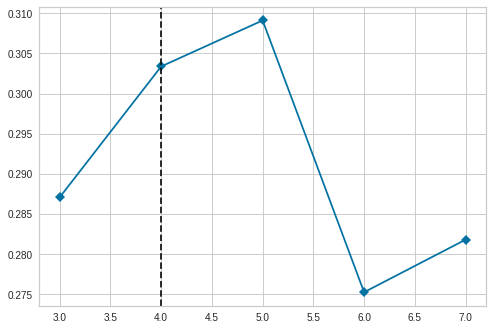

In [11]:
from sklearn.cluster import KMeans

from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,8), metric="silhouette", timings=False)

print(visualizer.fit(customers_scale))

In [12]:
# Your code here:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=4)

labels = model.fit_predict(customers_scale)

customers_scale["label"] = labels
customers_scale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,label
0,2,3,0.052933,0.523568,-0.041115,-0.589367,-0.043569,-0.066339,1
1,2,3,-0.391302,0.544458,0.170318,-0.270136,0.086407,0.089151,1
2,2,3,-0.447029,0.408538,-0.028157,-0.137536,0.133232,2.243293,1
3,1,3,0.100111,-0.624020,-0.392977,0.687144,-0.498588,0.093411,0
4,2,3,0.840239,-0.052396,-0.079356,0.173859,-0.231918,1.299347,0


Count the values in `labels`.

In [13]:
# Your code here:
customers_scale["label"].value_counts()

0    318
1    111
3     10
2      1
Name: label, dtype: int64

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [14]:
# Your code here
from sklearn.cluster import DBSCAN
customers_prueba = DBSCAN(eps=0.5).fit(customers_scale)

customers['labels_DBSCAN'] = customers_prueba.labels_
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,-1
1,2,3,7057,9810,9568,1762,3293,1776,-1
2,2,3,6353,8808,7684,2405,3516,7844,-1
3,1,3,13265,1196,4221,6404,507,1788,1
4,2,3,22615,5410,7198,3915,1777,5185,-1


In [15]:
customers_prueba2 = DBSCAN(eps=0.5, metric ="manhattan").fit(customers_scale)
customers2 = customers.copy()
customers2['labels_DBSCAN'] = customers_prueba2.labels_
customers2.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,-1
1,2,3,7057,9810,9568,1762,3293,1776,-1
2,2,3,6353,8808,7684,2405,3516,7844,-1
3,1,3,13265,1196,4221,6404,507,1788,-1
4,2,3,22615,5410,7198,3915,1777,5185,-1


In [16]:
customers_prueba3 = DBSCAN(eps=0.5,metric="cityblock").fit(customers_scale)
customers3 = customers.copy()
customers3['labels_DBSCAN'] = customers_prueba3.labels_
customers3.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,-1
1,2,3,7057,9810,9568,1762,3293,1776,-1
2,2,3,6353,8808,7684,2405,3516,7844,-1
3,1,3,13265,1196,4221,6404,507,1788,-1
4,2,3,22615,5410,7198,3915,1777,5185,-1


Count the values in `labels_DBSCAN`.

In [17]:
# Your code here
print(f"Customers : {customers['labels_DBSCAN'].value_counts()},\n Customers2 :{customers2['labels_DBSCAN'].value_counts()},\nCustomers3 : {customers3['labels_DBSCAN'].value_counts()}")

Customers : -1    255
 1    130
 5     22
 4      7
 6      6
 2      5
 7      5
 3      5
 0      5
Name: labels_DBSCAN, dtype: int64,
 Customers2 :-1    393
 0     41
 1      6
Name: labels_DBSCAN, dtype: int64,
Customers3 : -1    393
 0     41
 1      6
Name: labels_DBSCAN, dtype: int64


# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

Text(0, 0.5, 'Milk')

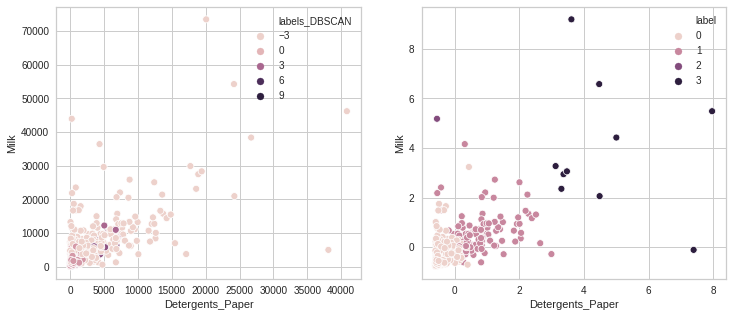

In [18]:
# Your code here:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure (figsize= (12,5))

plt.subplot(1,2,1)
ax = sns.scatterplot(customers["Detergents_Paper"],customers["Milk"], hue=customers.labels_DBSCAN)
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")

plt.subplot(1,2,2)
ax = sns.scatterplot(customers_scale["Detergents_Paper"],customers_scale["Milk"], hue= customers_scale.label)
plt.xlabel("Detergents_Paper")
plt.ylabel("Milk")

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

Text(0, 0.5, 'Fresh')

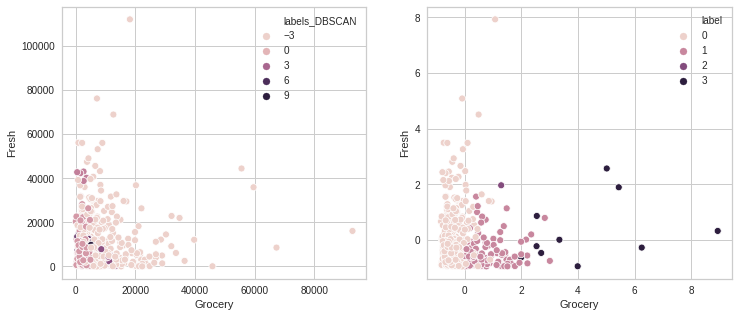

In [19]:
# Your code here:
plt.figure (figsize= (12,5))
plt.subplot(1,2,1)
ax = sns.scatterplot(customers["Grocery"],customers["Fresh"], hue=customers.labels_DBSCAN)
plt.xlabel("Grocery")
plt.ylabel("Fresh")

plt.subplot(1,2,2)
ax = sns.scatterplot(customers_scale["Grocery"],customers_scale["Fresh"], hue= customers_scale.label)
plt.xlabel("Grocery")
plt.ylabel("Fresh")

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

Text(0, 0.5, 'Delicassen')

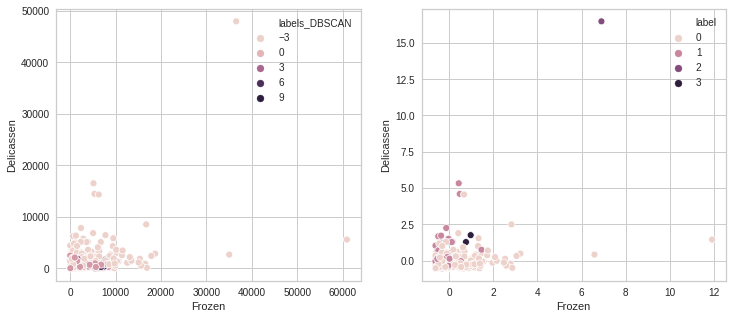

In [20]:
# Your code here:
plt.figure (figsize= (12,5))
plt.subplot(1,2,1)
ax = sns.scatterplot(customers["Frozen"],customers["Delicassen"], hue=customers.labels_DBSCAN)
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

plt.subplot(1,2,2)
ax = sns.scatterplot(customers_scale["Frozen"],customers_scale["Delicassen"], hue= customers_scale.label)
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [21]:
# Your code here:
customers = pd.concat([ customers,customers_scale.label],axis=1, join='inner')


In [22]:
customersGroup = customers.groupby(["labels_DBSCAN","label"]).mean()#.agg({["Channel","Region","Fresh","Milk","Grocery","Frozen","Detergents_Paper","Delicassen"]: "mean"})
display(customersGroup)

Fresh          Milk       Grocery        Frozen  \
labels_DBSCAN label                                                           
-1            0      18160.206897   4863.965517   5600.331034   5153.296552   
              1       6780.939394  10459.202020  16271.979798   1549.676768   
              2      36847.000000  43950.000000  20170.000000  36534.000000   
              3      15964.900000  34708.500000  48536.900000   3054.600000   
 0            0      11401.000000   3536.200000   6729.000000    720.200000   
 1            0       9128.823077   1862.438462   2423.530769   2131.430769   
 2            0      41446.600000   1421.200000   2167.600000   1276.400000   
 3            1       2357.200000  10224.800000  11862.800000    609.600000   
 4            1       3068.142857   6095.857143  10355.000000    994.000000   
 5            0       9837.863636   1751.863636   2161.681818   1513.181818   
 6            0       6823.000000   1943.000000   2372.666667   6780.333333   
 7            0       7494.600000   1537.600000   3383.000000   2575.400000   

                     Detergents_Paper    Delicassen  
labels_DBSCAN label                                  
-1            0           1200.896552   1814.344828  
              1           6948.111111   1919.888889  
              2            239.000000  47943.000000  
              3          24875.200000   2942.800000  
 0            0           3561.000000    258.200000  
 1            0            496.576923    741.946154  
 2            0            416.200000    784.800000  
 3            1           5780.000000    572.800000  
 4            1           4675.571429   1826.428571  
 5            0            333.954545    669.045455  
 6            0            386.500000    613.666667  
 7            0            227.400000    941.000000

Which algorithm appears to perform better?

In [23]:
# Your observations here
# Parece que el que funciona mejor es el labels_DBSCAN ya que con más pruebas saca menos medias o es al reves????
# no me entero con esto

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

/home/sergio/.local/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/sergio/.local/lib/python3.6/site-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/sergio/.local/lib/python3.6/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
/home/sergio/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return Non

KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd18187a2e8>,
                 k=None, locate_elbow=True, metric='silhouette', model=None,
                 timings=False)


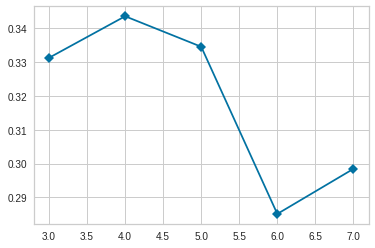

In [28]:
# Your code here
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,8), metric="silhouette", timings=False)

print(visualizer.fit(customers_scale))


KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd1817f7e48>,
                 k=None, locate_elbow=True, metric='silhouette', model=None,
                 timings=False)


/home/sergio/.local/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


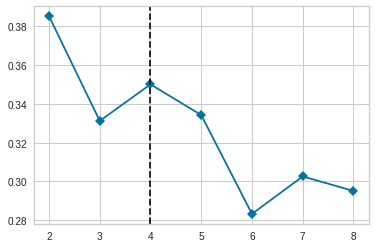

In [29]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,9), metric="silhouette", timings=False)

print(visualizer.fit(customers_scale))


In [25]:
# Your comment here
# SEgun vemos en la gráfica el idóneo es con 4 n_clusters

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

Text(0, 0.5, 'Delicassen')

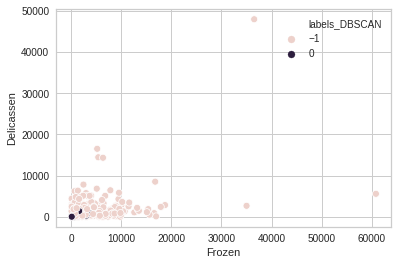

In [33]:
# Your code here
customers_prueba4 = DBSCAN(eps=0.3,min_samples=6).fit(customers_scale)
customers4 = customers.copy()

customers4['labels_DBSCAN'] = customers_prueba4.labels_

ax = sns.scatterplot(customers["Frozen"],customers["Delicassen"], hue=customers4.labels_DBSCAN)
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

Text(0, 0.5, 'Delicassen')

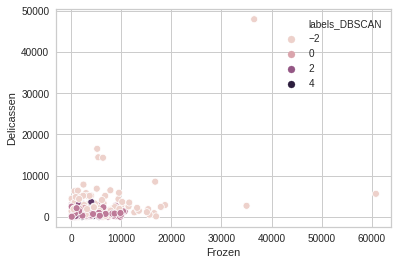

In [34]:
# Your comment here
customers_prueba5 = DBSCAN(eps=0.8,min_samples=9).fit(customers_scale)
customers5 = customers.copy()

customers5['labels_DBSCAN'] = customers_prueba5.labels_

ax = sns.scatterplot(customers["Frozen"],customers["Delicassen"], hue=customers5.labels_DBSCAN)
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

Text(0, 0.5, 'Delicassen')

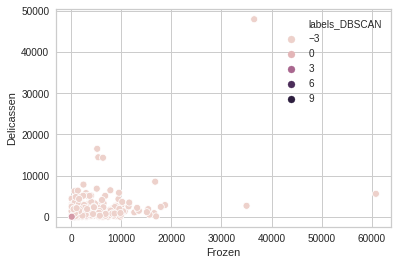

In [35]:
customers_prueba6 = DBSCAN(eps=0.2,min_samples=3).fit(customers_scale)
customers6 = customers.copy()

customers6['labels_DBSCAN'] = customers_prueba6.labels_

ax = sns.scatterplot(customers["Frozen"],customers["Delicassen"], hue=customers6.labels_DBSCAN)
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

Text(0, 0.5, 'Delicassen')

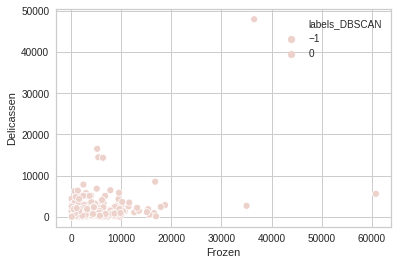

In [36]:
customers_prueba7 = DBSCAN(eps=0.1,min_samples=10).fit(customers_scale)
customers7 = customers.copy()

customers7['labels_DBSCAN'] = customers_prueba7.labels_

ax = sns.scatterplot(customers["Frozen"],customers["Delicassen"], hue=customers7.labels_DBSCAN)
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

Text(0, 0.5, 'Delicassen')

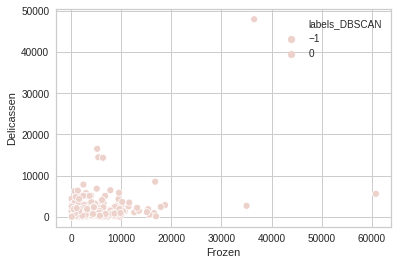

In [37]:
customers_prueba8 = DBSCAN(eps=0.2,min_samples=10).fit(customers_scale)
customers8 = customers.copy()

customers8['labels_DBSCAN'] = customers_prueba8.labels_

ax = sns.scatterplot(customers["Frozen"],customers["Delicassen"], hue=customers8.labels_DBSCAN)
plt.xlabel("Frozen")
plt.ylabel("Delicassen")

### Comentario:
     Veo que si bajas la distancia y introduces menos samples ayade más clusters para hacer la medida. 